In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
device = "cpu"
if T.cuda.is_available():
  device = "cuda"
elif T.backends.mps.is_available():
  device = "mps"

In [3]:
training_data = datasets.CIFAR10(
  root="data",
  train=True,
  download=True,
  transform=transforms.Compose([
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
)
test_data = datasets.CIFAR10(
  root="data",
  train=False,
  download=True,
  transform=transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
)

Files already downloaded and verified
Files already downloaded and verified


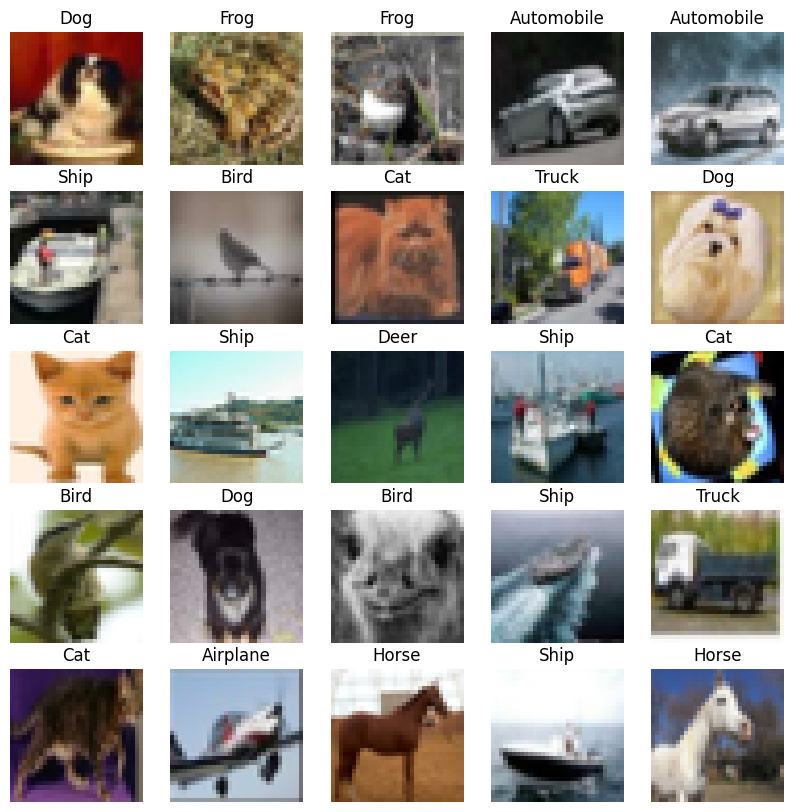

In [53]:
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}
# figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(1, cols * rows + 1):
    # Randomly sample an image from the test dataset
    sample_idx = T.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    
    # Convert tensor to numpy array and rearrange axes for plt.imshow()
    img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    
    # Display the image in the grid
    plt.subplot(rows, cols, i)
    plt.title(labels_map[label]) 
    plt.imshow(img)
    plt.axis('off')  # Optionally turn off axis for a cleaner look

plt.show()

In [21]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(latent_dim + 1, 512 * 8 * 8)

        self.conv1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = out.view(-1, 512, 8, 8)
        # print(out.shape)
        out = self.upsample(out)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.upsample(out)
        out = self.conv4(out)
        out = self.conv5(out)
        
        return out



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.LeakyReLU(),
        )
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # print("X", x.shape)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        # print("T", out.shape)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)

        return out

In [30]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCEWithLogitsLoss()
optim_d = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [23]:
def show_and_save_images(iter: int = 1, save: bool = False):
    generator.eval()
    
    rows = 10
    cols = 10
    
    with T.inference_mode():
      fig = plt.figure(figsize=(10, 10))
      for i in range(1, (rows * cols) + 1):
        z = T.randn((1, 101)).to(device)
        # noise_input = noise_inputs[i-1]
        # noise_input = noise_input.unsqueeze_(dim=0).to(device)
        gan_output = generator(z)
        gan_output = gan_output.squeeze().to('cpu').detach().permute(1, 2, 0).numpy()
        fig.add_subplot(rows, cols, i)
        plt.imshow(gan_output.reshape((32, 32, 3)), cmap='gray')
        plt.axis(False)
      if save:
        fig.savefig(f'{iter}.png')
      plt.close()


show_and_save_images(200, False)

In [ ]:
g_losses = []
d_losses = []

train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
for epoch in tqdm(range(300)):  
  generator.train()
  discriminator.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    valid = T.ones((images.size(0), 1)).to(device)
    fake = T.zeros((images.size(0), 1)).to(device)
    
    optim_g.zero_grad()
    z = T.randn((images.size(0), 100)).to(device)
    z = T.cat((z, labels.reshape((labels.size(0), 1)) / 10), dim=1).to(device)
    generated_imgs = generator(z)
    l = discriminator(generated_imgs)
    g_loss = criterion(l, valid)
    g_losses.append(g_loss.item())
    g_loss.backward()
    optim_g.step()

    optim_d.zero_grad()
    real_loss = criterion(discriminator(images), valid)
    fake_loss = criterion(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2
    d_losses.append(d_loss.item())
    d_loss.backward()
    optim_d.step()

  if (epoch + 1) % 10 == 0:
    show_and_save_images(epoch + 241, True)
# plt.plot(losses)
# plt.show()

  0%|          | 0/760 [00:00<?, ?it/s]

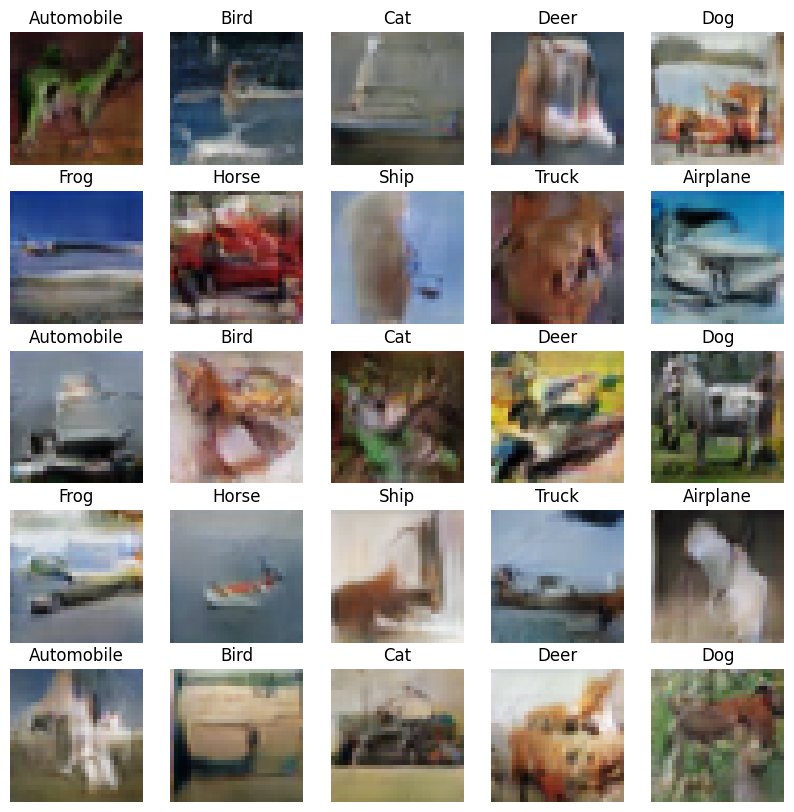

In [59]:
generator.eval()

rows = 5
cols = 5

with T.inference_mode():
  fig = plt.figure(figsize=(10, 10))
  for i in range(1, (rows * cols) + 1):
    z = T.randn((1, 101)).to(device)
    z[0][-1] = (i % 10) / 10.0
    # noise_input = noise_inputs[i-1]
    # noise_input = noise_input.unsqueeze_(dim=0).to(device)
    gan_output = generator(z)
    gan_output = gan_output.squeeze().to('cpu').detach().permute(1, 2, 0).numpy()
    plt.subplot(rows, cols, i)
    plt.title(labels_map[i%10])
    plt.imshow(gan_output)
    plt.axis(False)
  plt.show()

# cols, rows = 5, 5
# fig = plt.figure(figsize=(10, 10))

# for i in range(1, cols * rows + 1):
#     # Randomly sample an image from the test dataset
#     sample_idx = T.randint(len(test_data), size=(1,)).item()
#     img, label = test_data[sample_idx]
    
#     # Convert tensor to numpy array and rearrange axes for plt.imshow()
#     img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    
#     # Display the image in the grid
#     plt.subplot(rows, cols, i)
#     plt.title(labels_map[label]) 
#     plt.imshow(img)
#     plt.axis('off')  # Optionally turn off axis for a cleaner look

# plt.show()